In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style
sns.set(style="whitegrid")
%matplotlib inline

# Load Data

In [ ]:
# Load datasets
original_listings = pd.read_csv('listings_NY.csv')

# --- Basic Info: Original Listings ---
print("\n=== Original Listings Dataset ===")
print("1. Info:")
original_listings.info()
print("\n2. Description (including non-numerics):")
print(original_listings.describe(include='all'))  # Include categorical columns
print("\n3. First 5 Rows:")
print(original_listings.head())
print("\n4. Missing Values:")
print(original_listings.isnull().sum() / len(original_listings) * 100)  # Show missing value percentages


=== Original Listings Dataset ===
1. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            37434 non-null  int64  
 1   listing_url                                   37434 non-null  object 
 2   scrape_id                                     37434 non-null  int64  
 3   last_scraped                                  37434 non-null  object 
 4   source                                        37434 non-null  object 
 5   name                                          37432 non-null  object 
 6   description                                   36441 non-null  object 
 7   neighborhood_overview                         20224 non-null  object 
 8   picture_url                                   37433 non-null  object 
 9   host_id          

# EDA (Exploratory Data Analysis)

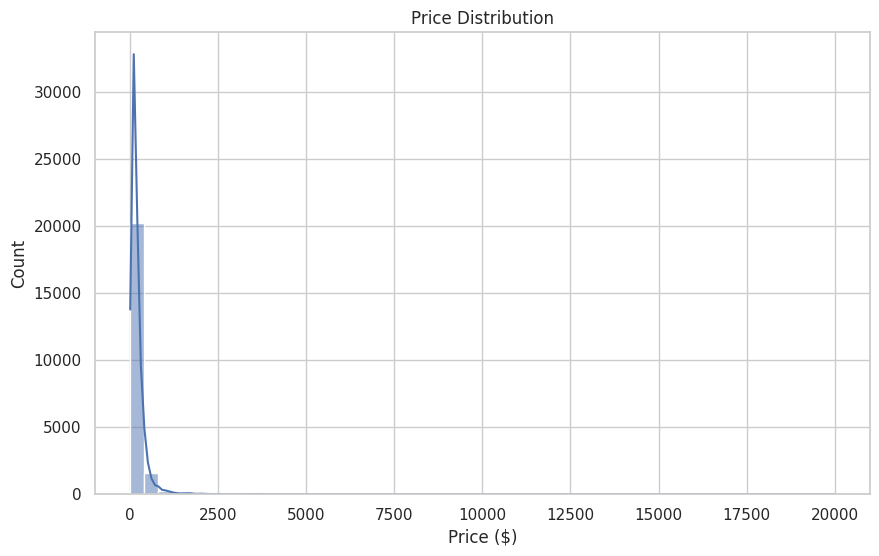

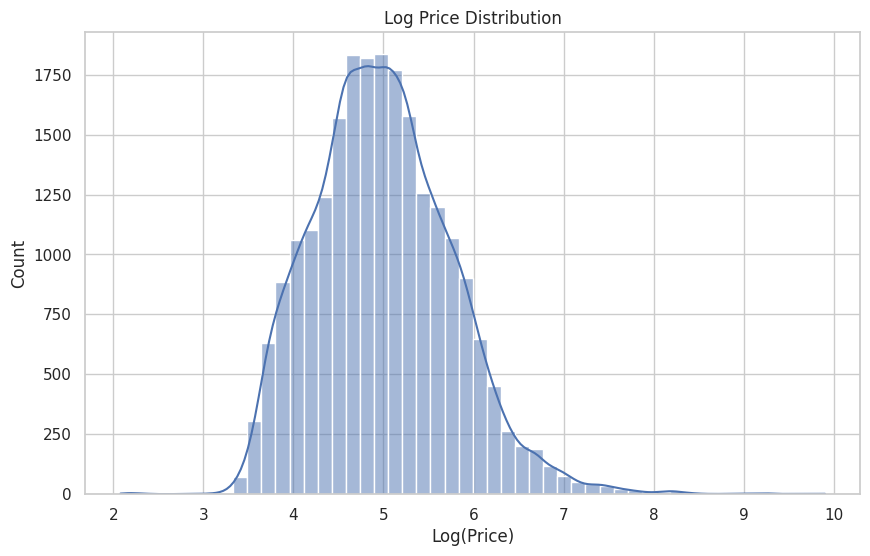

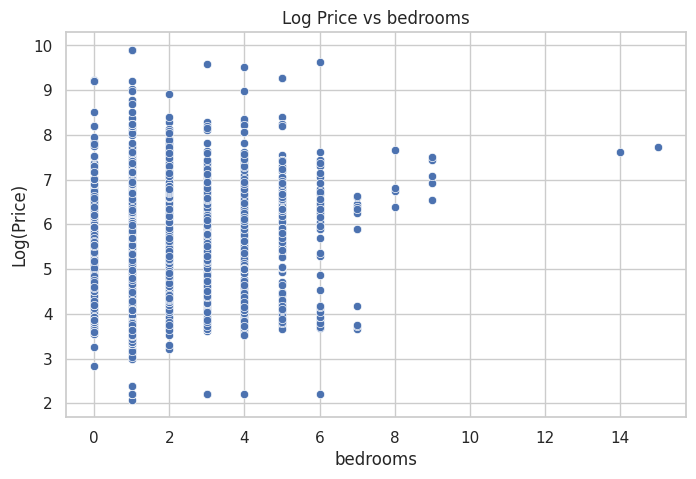

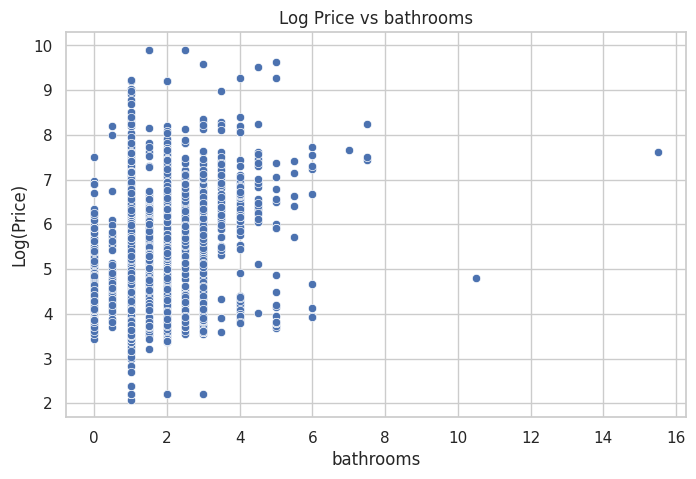

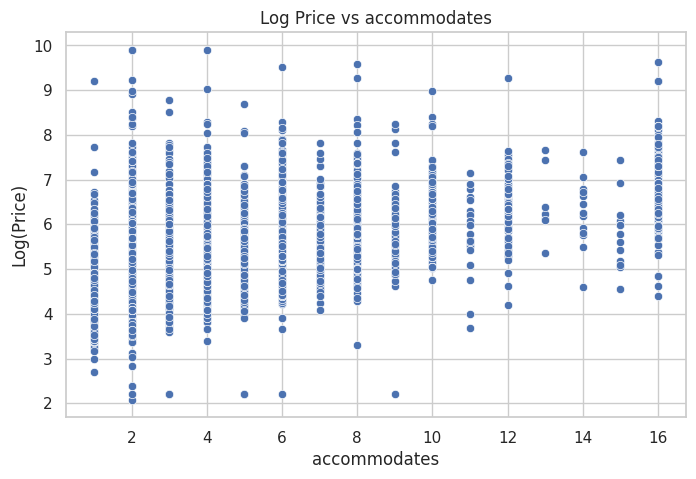

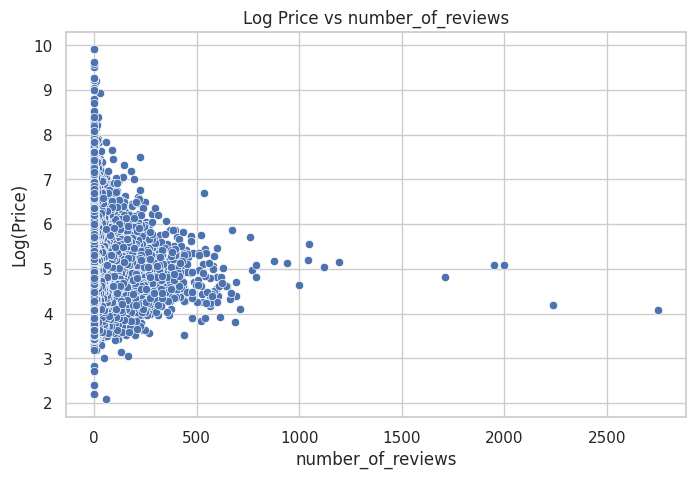

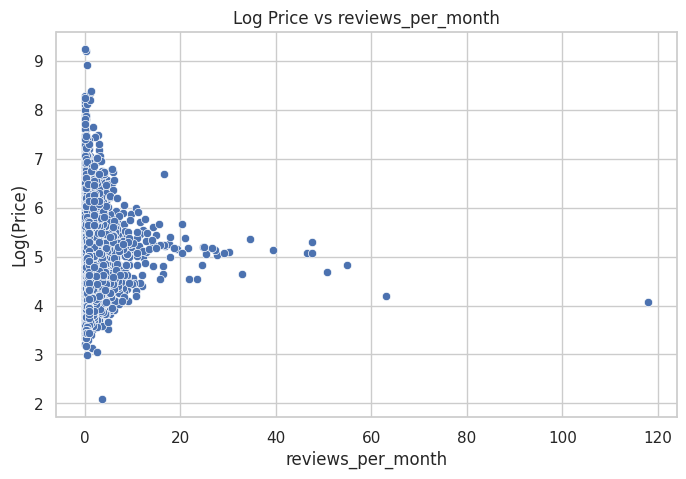

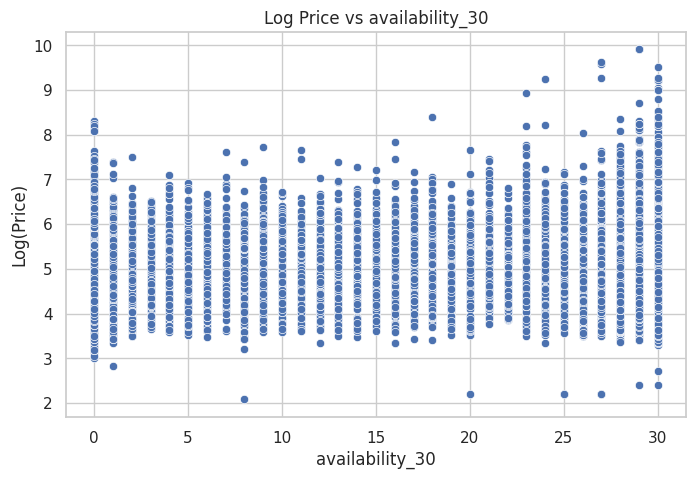

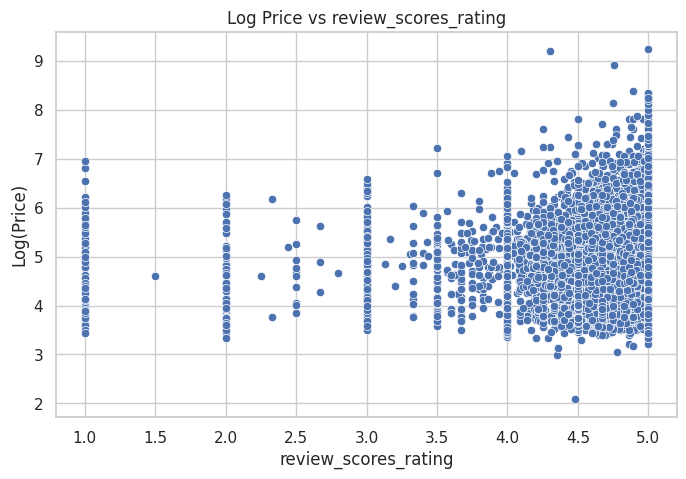

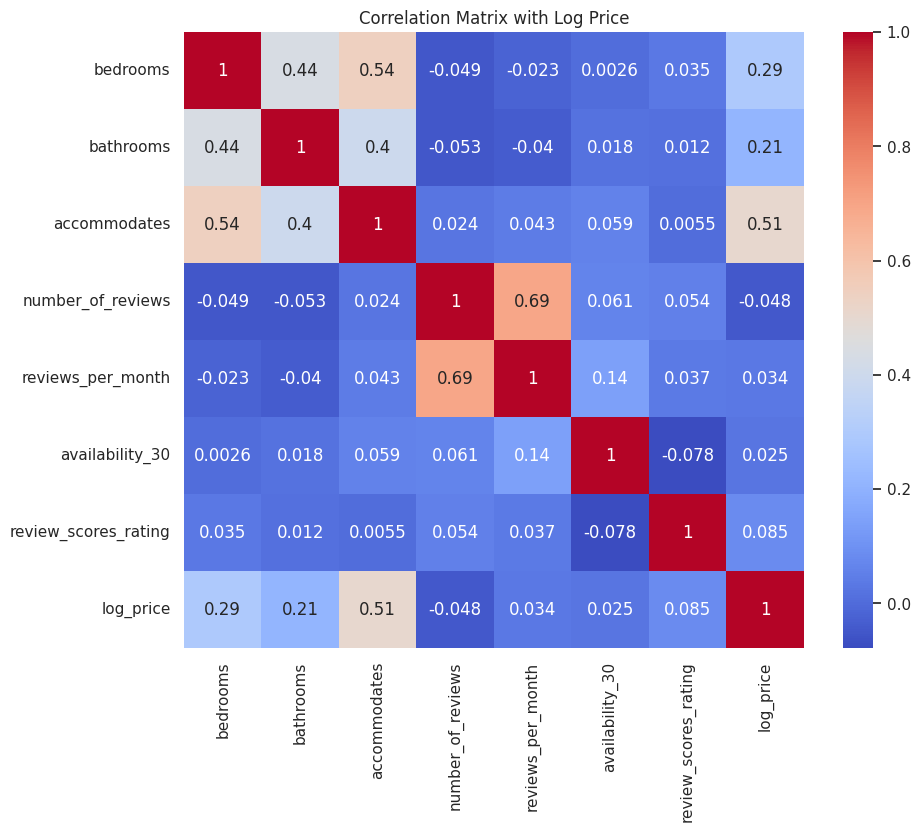

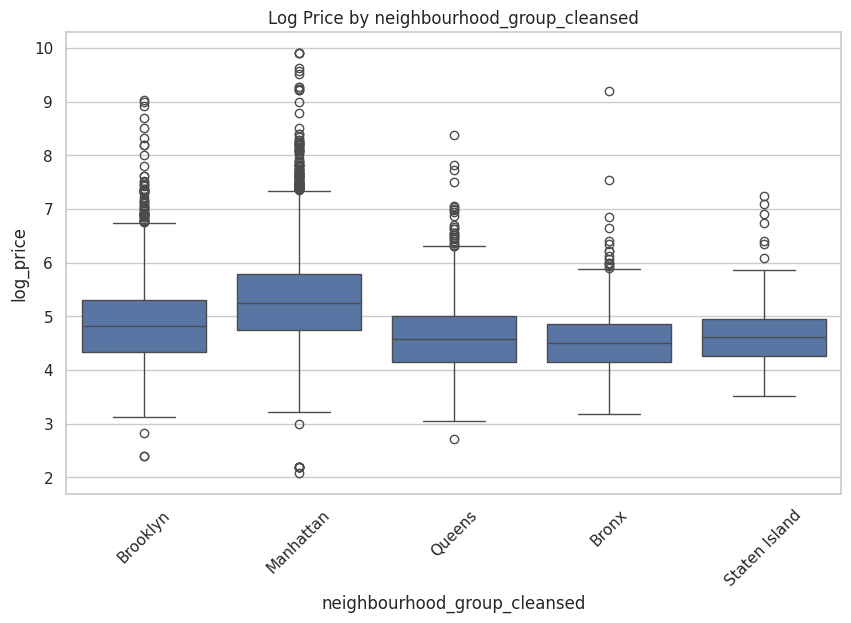

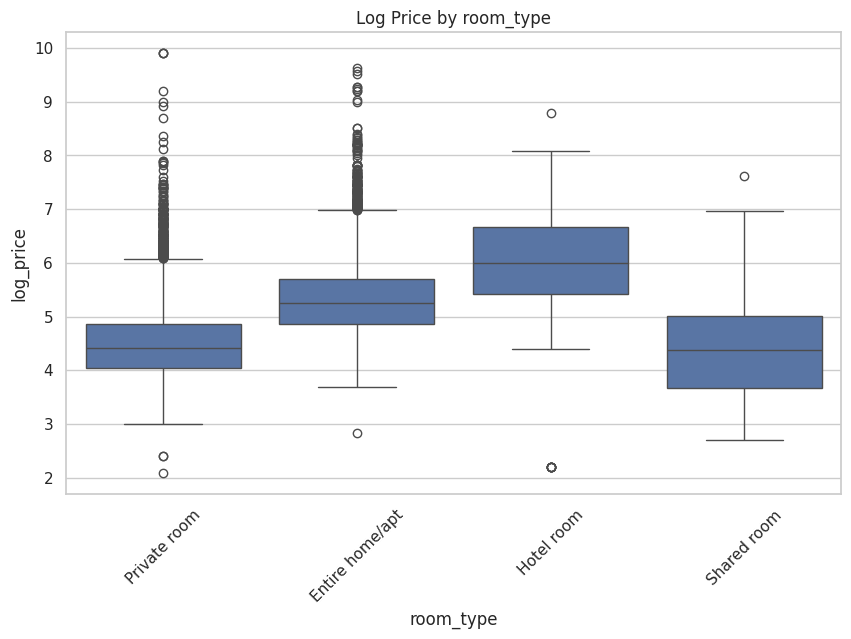

In [ ]:
listings = original_listings.copy()

# Clean the price column (remove "$" and ",", then convert to float)
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Plot price distribution
plt.figure(figsize=(10,6))
sns.histplot(listings['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.show()

# Create log-transformed price
listings['log_price'] = np.log1p(listings['price'])

# Plot log(price) distribution
plt.figure(figsize=(10,6))
sns.histplot(listings['log_price'], bins=50, kde=True)
plt.title('Log Price Distribution')
plt.xlabel('Log(Price)')
plt.show()

# Scatter plots: numerical features vs log(price)
numeric_features = ['bedrooms', 'bathrooms', 'accommodates',
                    'number_of_reviews', 'reviews_per_month',
                    'availability_30', 'review_scores_rating']

for feature in numeric_features:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=listings[feature], y=listings['log_price'])
    plt.title(f'Log Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Log(Price)')
    plt.show()

# Correlation heatmap among numeric features and log(price)
corr_features = numeric_features + ['log_price']
corr_matrix = listings[corr_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Log Price')
plt.show()

# Box plots: categorical features vs log(price)
categorical_features = ['neighbourhood_group_cleansed', 'room_type']

# Copy categorical columns to listings
for col in categorical_features:
    listings[col] = original_listings[col]

for feature in categorical_features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=feature, y='log_price', data=listings)
    plt.title(f'Log Price by {feature}')
    plt.xticks(rotation=45)
    plt.show()


# Preprocessing

## Select features

In [ ]:
# Select relevant features for modeling
selected_features = ['price', 'log_price', 'bedrooms', 'bathrooms', 'accommodates',
                     'neighbourhood_group_cleansed', 'room_type']

# Create a copy with only the selected features
listings = listings[selected_features].copy()

## Drop missing values

In [ ]:
# Check missing value percentages before dropping
print("\nMissing value percentage before dropping:")
print(listings.isnull().sum() / len(listings) * 100)

# Print number of records before dropping missing values
print(f"\nNumber of records before dropping missing values: {listings.shape[0]}")

# Drop rows with missing values in selected key columns
listings = listings.dropna(subset=['bedrooms', 'bathrooms', 'accommodates', 'neighbourhood_group_cleansed', 'room_type'])

# Print number of records after dropping missing values
print(f"Number of records after dropping missing values: {listings.shape[0]}")


Missing value percentage before dropping:
price                           40.407117
log_price                       40.407117
bedrooms                        15.790458
bathrooms                       39.886200
accommodates                     0.000000
neighbourhood_group_cleansed     0.000000
room_type                        0.000000
dtype: float64

Number of records before dropping missing values: 37434
Number of records after dropping missing values: 22454


## Remove price outliers

In [ ]:
# Calculate the interquartile range (IQR) for the price column
Q1 = listings['price'].quantile(0.25)
Q3 = listings['price'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers based on 1.5*IQR rule
listings = listings[(listings['price'] >= Q1 - 1.5 * IQR) & (listings['price'] <= Q3 + 1.5 * IQR)]

# Print number of records after removing outliers
print(f"Number of records after removing outliers: {listings.shape[0]}")


Number of records after removing outliers: 20776


## One-hot encoding

In [ ]:
# Print number of columns before one-hot encoding
print(f"\nNumber of columns before one-hot encoding: {listings.shape[1]}")

# Perform one-hot encoding on categorical features
listings = pd.get_dummies(listings, columns=['neighbourhood_group_cleansed', 'room_type'], drop_first=True)

# Print number of columns after one-hot encoding
print(f"Number of columns after one-hot encoding: {listings.shape[1]}")

# Display generated column names
print("Generated columns:")
print(listings.columns)


Number of columns before one-hot encoding: 7
Number of columns after one-hot encoding: 12
Generated columns:
Index(['price', 'log_price', 'bedrooms', 'bathrooms', 'accommodates',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')


In [ ]:
# Print the final shape of the cleaned dataset
print(f"\nFinal shape of the cleaned listings dataset: {listings.shape}")

# Display the first 5 rows of the cleaned dataset
print("\nFirst 5 rows of the cleaned dataset:")
print(listings.head())

# Final check for any remaining missing values
print("\nFinal missing value check:")
print(listings.isnull().sum())


Final shape of the cleaned listings dataset: (20776, 12)

First 5 rows of the cleaned dataset:
   price  log_price  bedrooms  bathrooms  accommodates  \
0  200.0   5.303305       1.0        1.0             1   
1   82.0   4.418841       1.0        1.0             2   
3  139.0   4.941642       1.0        1.0             2   
4  130.0   4.875197       1.0        1.0             2   
7   96.0   4.574711       2.0        1.0             3   

   neighbourhood_group_cleansed_Brooklyn  \
0                                   True   
1                                  False   
3                                  False   
4                                   True   
7                                   True   

   neighbourhood_group_cleansed_Manhattan  \
0                                   False   
1                                    True   
3                                    True   
4                                   False   
7                                   False   

   neighbourhood_gr

#Data Modelling

## Linear Regression

### Model Training and Validation

Train size: 12465, Exploration size: 4155, Test size: 4156

[Linear Regression] Exploration Set Evaluation:
R² (log scale): 0.421
RMSE (log scale): 0.489

[Linear Regression] Test Set Evaluation (Log Scale):
R² (log scale): 0.411
RMSE (log scale): 0.485

[Linear Regression] Test Set Evaluation (Original Price):
R² (original price): 0.301
RMSE (original price): 82.78


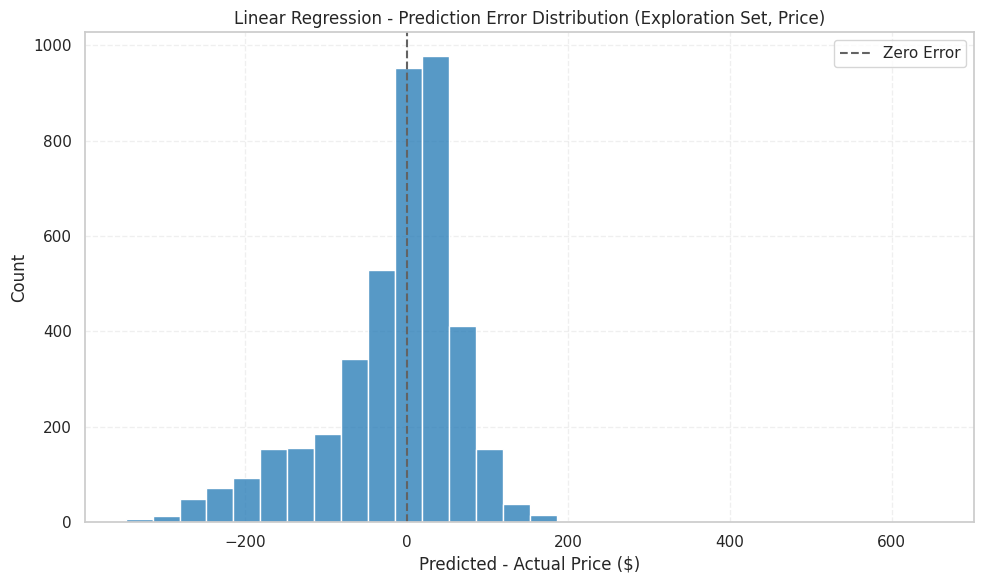

In [ ]:
from sklearn.linear_model import LinearRegression

# Define features (X) and target (y)
X = listings.drop(['price', 'log_price'], axis=1)  # Drop price and log_price from features
y = listings['log_price']  # Use log-transformed price as target

# Split the data into training, exploration (validation), and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_explore, X_test, y_explore, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the size of each split
print(f"Train size: {X_train.shape[0]}, Exploration size: {X_explore.shape[0]}, Test size: {X_test.shape[0]}")

# --- Train model ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# --- Predict ---
y_pred_explore_lr = lr_model.predict(X_explore)
y_pred_test_lr = lr_model.predict(X_test)

# --- Evaluate on Exploration Set ---
print("\n[Linear Regression] Exploration Set Evaluation:")
print(f"R² (log scale): {r2_score(y_explore, y_pred_explore_lr):.3f}")
print(f"RMSE (log scale): {np.sqrt(mean_squared_error(y_explore, y_pred_explore_lr)):.3f}")

# --- Evaluate on Test Set (log scale) ---
print("\n[Linear Regression] Test Set Evaluation (Log Scale):")
print(f"R² (log scale): {r2_score(y_test, y_pred_test_lr):.3f}")
print(f"RMSE (log scale): {np.sqrt(mean_squared_error(y_test, y_pred_test_lr)):.3f}")

# --- Inverse transform to original price ---
y_pred_test_price_lr = np.expm1(y_pred_test_lr)
y_test_price = np.expm1(y_test)

# --- Evaluate on Test Set (original price) ---
print("\n[Linear Regression] Test Set Evaluation (Original Price):")
print(f"R² (original price): {r2_score(y_test_price, y_pred_test_price_lr):.3f}")
print(f"RMSE (original price): {np.sqrt(mean_squared_error(y_test_price, y_pred_test_price_lr)):.2f}")

# --- Optional: Visualization (Error distribution for exploration set) ---
explore_results_lr = pd.DataFrame({
    'Actual_LogPrice': y_explore,
    'Predicted_LogPrice': y_pred_explore_lr,
    'Error_Log': y_pred_explore_lr - y_explore,
    'Actual_Price': np.expm1(y_explore),
    'Predicted_Price': np.expm1(y_pred_explore_lr),
    'Error_Price': np.expm1(y_pred_explore_lr) - np.expm1(y_explore)
})

plt.figure(figsize=(10, 6))
sns.histplot(explore_results_lr['Error_Price'], bins=30, color='#1F77B4')
plt.axvline(0, color='#636363', linestyle='--', label='Zero Error')
plt.title('Linear Regression - Prediction Error Distribution (Exploration Set, Price)')
plt.xlabel('Predicted - Actual Price ($)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Test Set Evaluation

In [ ]:
# Predict on the test set (Linear Regression)
y_pred_test_lr = lr_model.predict(X_test)

# Evaluate model performance on the test set (log price)
print("\n[Linear Regression] Test Set Evaluation (Log Scale):")
print(f"R² (log scale): {r2_score(y_test, y_pred_test_lr):.3f}")
print(f"RMSE (log scale): {np.sqrt(mean_squared_error(y_test, y_pred_test_lr)):.3f}")

# Inverse transform predictions and actuals back to original price scale
y_pred_test_price_lr = np.expm1(y_pred_test_lr)
y_test_price = np.expm1(y_test)

# Evaluate model performance on the test set (original price)
print("\n[Linear Regression] Test Set Evaluation (Original Price):")
print(f"R² (original price): {r2_score(y_test_price, y_pred_test_price_lr):.3f}")
print(f"RMSE (original price): {np.sqrt(mean_squared_error(y_test_price, y_pred_test_price_lr)):.2f}")

# --- Display Linear Regression Full Formula ---

# Get intercept and coefficients
intercept = lr_model.intercept_
coefficients = lr_model.coef_
features = X_train.columns

# Print the full Linear Regression formula
print("Linear Regression Formula:")
formula = f"Log(Price) = {intercept:.3f}"
for feature, coef in zip(features, coefficients):
    sign = "+" if coef >= 0 else "-"
    formula += f" {sign} {abs(coef):.3f} * {feature}"
print(formula)


[Linear Regression] Test Set Evaluation (Log Scale):
R² (log scale): 0.411
RMSE (log scale): 0.485

[Linear Regression] Test Set Evaluation (Original Price):
R² (original price): 0.301
RMSE (original price): 82.78
Linear Regression Formula:
Log(Price) = 4.573 + 0.045 * bedrooms - 0.023 * bathrooms + 0.091 * accommodates + 0.182 * neighbourhood_group_cleansed_Brooklyn + 0.416 * neighbourhood_group_cleansed_Manhattan + 0.025 * neighbourhood_group_cleansed_Queens - 0.015 * neighbourhood_group_cleansed_Staten Island + 0.090 * room_type_Hotel room - 0.512 * room_type_Private room - 0.524 * room_type_Shared room


### Model Visualizations and Feature Importance

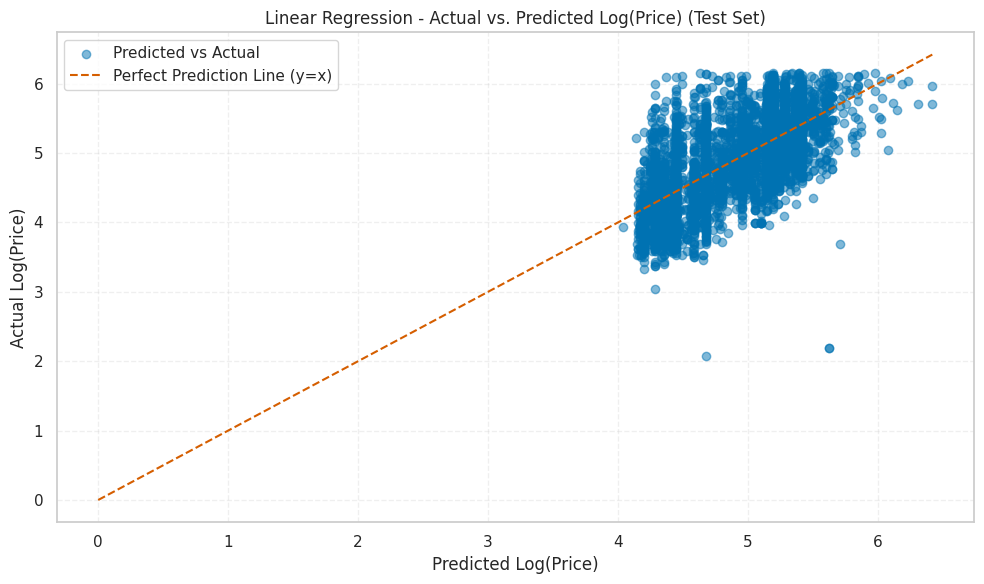

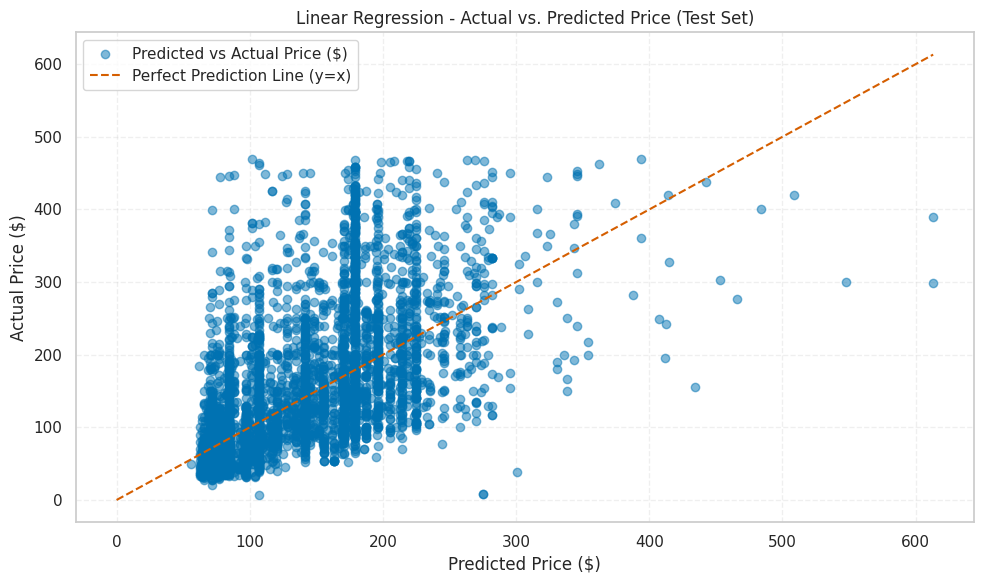

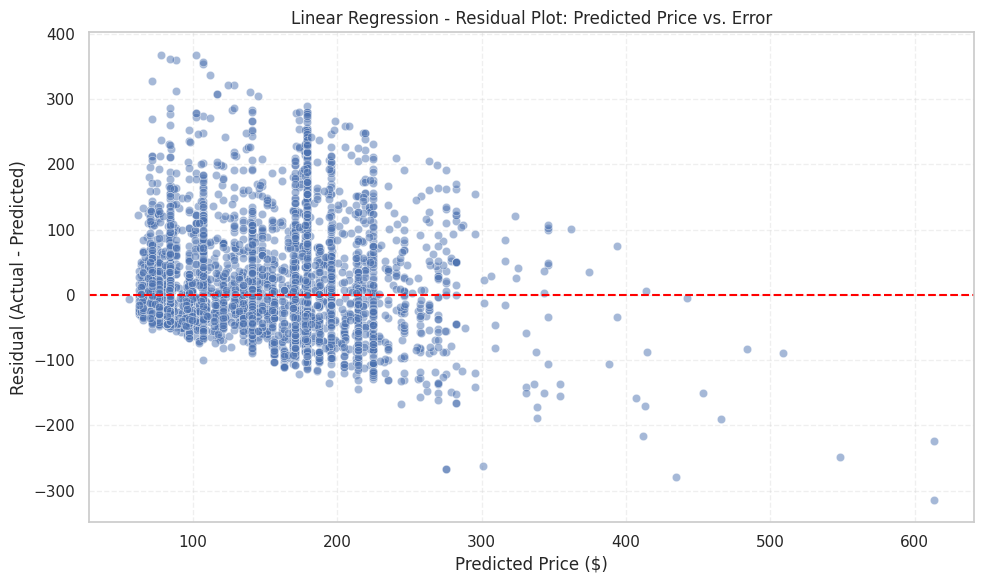

<ipython-input-36-db5fd269b172>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10), palette='viridis')


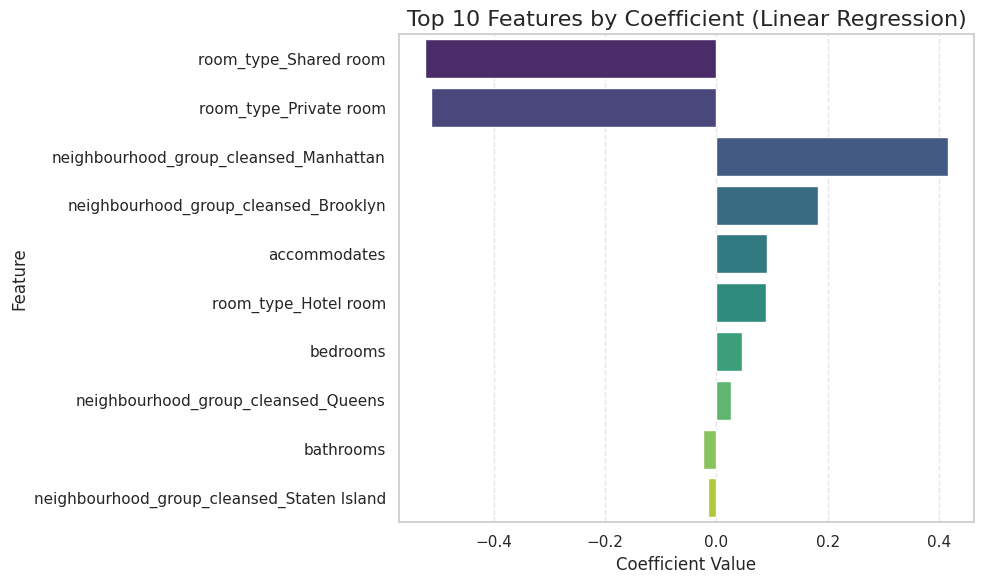

In [ ]:
# Scatter plot: Predicted vs. Actual (log price) - Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_lr, y_test, alpha=0.5, color='#0072B2', label='Predicted vs Actual')
max_val = max(y_test.max(), y_pred_test_lr.max())
plt.plot([0, max_val], [0, max_val], '--', color='#D55E00', label='Perfect Prediction Line (y=x)')
plt.title('Linear Regression - Actual vs. Predicted Log(Price) (Test Set)')
plt.xlabel('Predicted Log(Price)')
plt.ylabel('Actual Log(Price)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs. Actual (original price) - Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_price_lr, y_test_price, alpha=0.5, color='#0072B2', label='Predicted vs Actual Price ($)')
max_val_price = max(y_test_price.max(), y_pred_test_price_lr.max())
plt.plot([0, max_val_price], [0, max_val_price], '--', color='#D55E00', label='Perfect Prediction Line (y=x)')
plt.title('Linear Regression - Actual vs. Predicted Price (Test Set)')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Actual Price ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Residual plot: Error distribution (original price) - Linear Regression
residuals_lr = y_test_price - y_pred_test_price_lr

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test_price_lr, y=residuals_lr, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title('Linear Regression - Residual Plot: Predicted Price vs. Error')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot Top 10 Linear Regression Coefficients with Viridis Color ---

# Create a DataFrame of all features and coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

# Visualize Top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10), palette='viridis')
plt.title('Top 10 Features by Coefficient (Linear Regression)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## RandomForest

### Model Training and Validation

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on exploration and test sets
y_pred_explore_rf = rf_model.predict(X_explore)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluate on exploration set (log scale)
print("\n[Random Forest] Exploration Set (Log Scale):")
print(f"R²: {r2_score(y_explore, y_pred_explore_rf):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_explore, y_pred_explore_rf)):.3f}")


[Random Forest] Exploration Set (Log Scale):
R²: 0.507
RMSE: 0.451


### Test Set Evaluation

In [ ]:
# Evaluate on test set (log scale)
print("\n[Random Forest] Test Set (Log Scale):")
print(f"R²: {r2_score(y_test, y_pred_test_rf):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_rf)):.3f}")

# Inverse transform predictions and actuals back to original price scale
y_pred_test_price_rf = np.expm1(y_pred_test_rf)
y_test_price = np.expm1(y_test)

# Evaluate on test set (original price)
print("\n[Random Forest] Test Set (Original Price):")
print(f"R² (original price): {r2_score(y_test_price, y_pred_test_price_rf):.3f}")
print(f"RMSE (original price): {np.sqrt(mean_squared_error(y_test_price, y_pred_test_price_rf)):.2f}")


[Random Forest] Test Set (Log Scale):
R²: 0.493
RMSE: 0.450

[Random Forest] Test Set (Original Price):
R² (original price): 0.398
RMSE (original price): 76.81


### Model Visualizations and Feature Importance

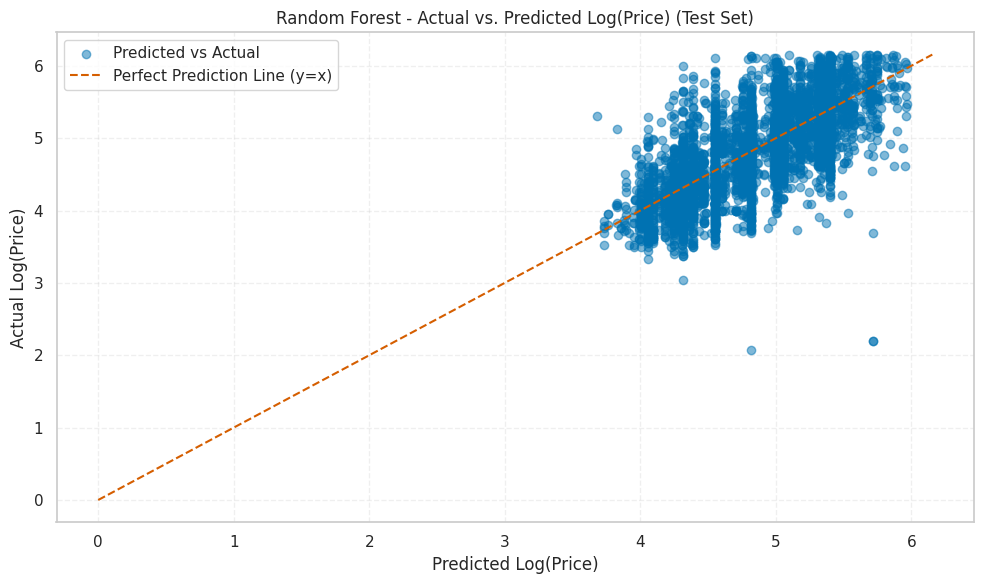

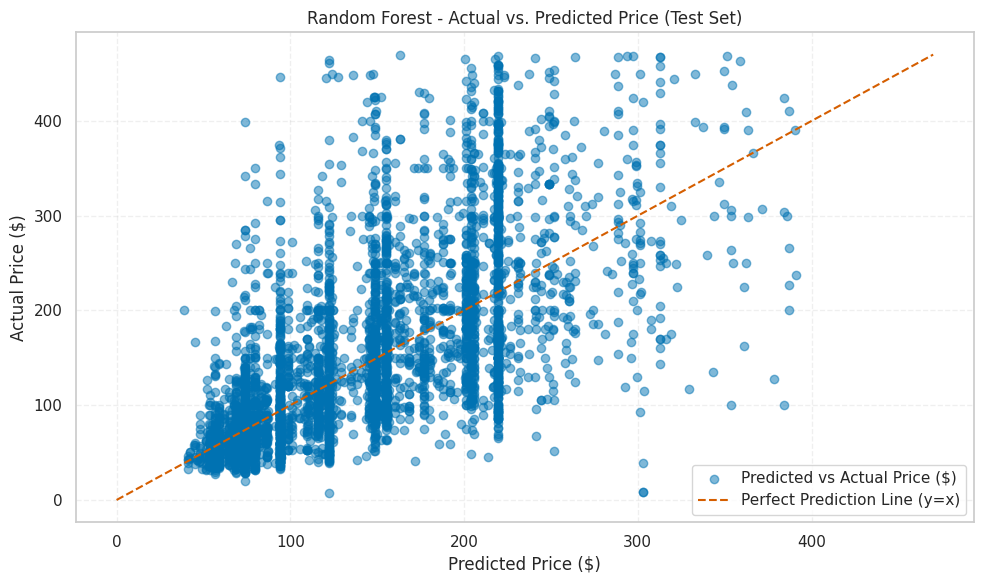

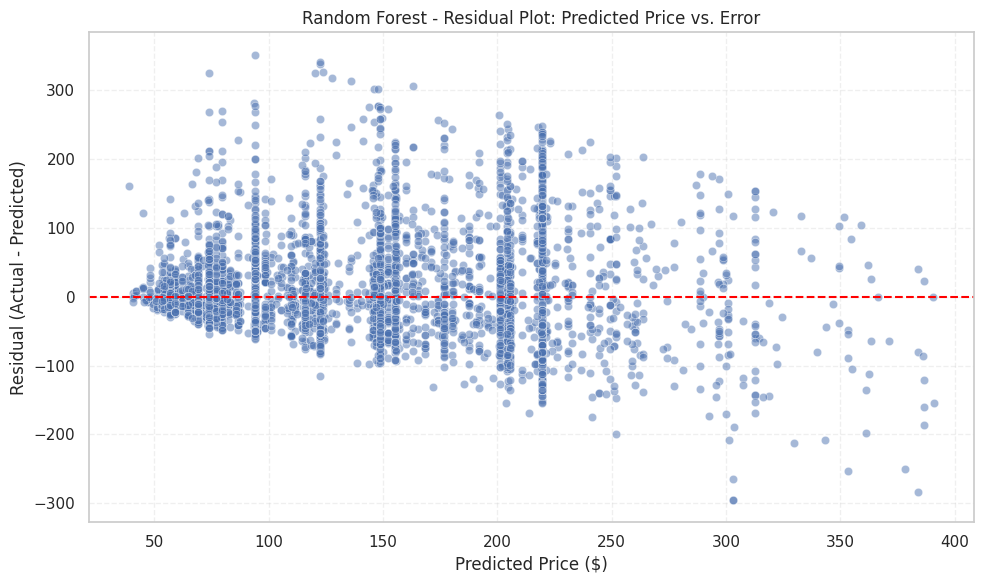

<ipython-input-15-5f12b3291850>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


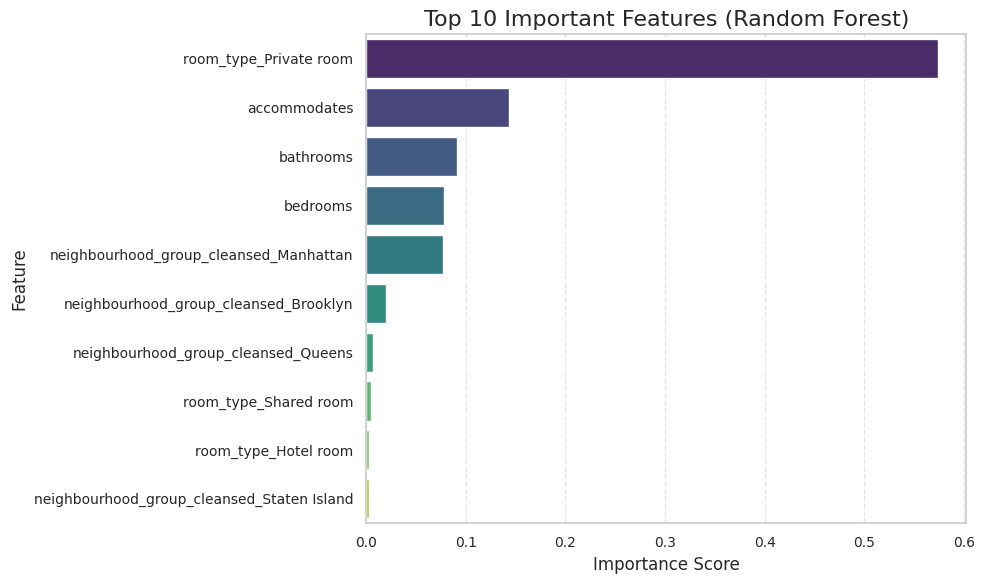

In [ ]:
# Scatter plot: Predicted vs. Actual (log scale)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_rf, y_test, alpha=0.5, color='#0072B2', label='Predicted vs Actual')
max_val = max(y_test.max(), y_pred_test_rf.max())
plt.plot([0, max_val], [0, max_val], '--', color='#D55E00', label='Perfect Prediction Line (y=x)')
plt.title('Random Forest - Actual vs. Predicted Log(Price) (Test Set)')
plt.xlabel('Predicted Log(Price)')
plt.ylabel('Actual Log(Price)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs. Actual (original price)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_price_rf, y_test_price, alpha=0.5, color='#0072B2', label='Predicted vs Actual Price ($)')
max_val_price = max(y_test_price.max(), y_pred_test_price_rf.max())
plt.plot([0, max_val_price], [0, max_val_price], '--', color='#D55E00', label='Perfect Prediction Line (y=x)')
plt.title('Random Forest - Actual vs. Predicted Price (Test Set)')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Actual Price ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Residual plot: Error distribution (original price)
residuals_rf = y_test_price - y_pred_test_price_rf

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test_price_rf, y=residuals_rf, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title('Random Forest - Residual Plot: Predicted Price vs. Error')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate feature importances from Random Forest model
importances_rf = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feat_imp_rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})
feat_imp_rf_df = feat_imp_rf_df.sort_values('Importance', ascending=False)

# Plot the top 10 important features with improved color and formatting
plt.figure(figsize=(10, 6))

# Use a modern color palette ('viridis') to enhance visual appeal
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_rf_df.head(10),
    palette='viridis'
)

# Set plot title and axis labels
plt.title('Top 10 Important Features (Random Forest)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Adjust tick label sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add light grid lines on x-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()



## XGBoost

### Model Training and Validation

In [ ]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on exploration and test sets
y_pred_explore_xgb = xgb_model.predict(X_explore)
y_pred_test_xgb = xgb_model.predict(X_test)

# Evaluate on exploration set (log scale)
print("\n[XGBoost] Exploration Set (Log Scale):")
print(f"R²: {r2_score(y_explore, y_pred_explore_xgb):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_explore, y_pred_explore_xgb)):.3f}")


[XGBoost] Exploration Set (Log Scale):
R²: 0.501
RMSE: 0.454


### Test Set Evaluation

In [ ]:
# Evaluate on test set (log scale)
print("\n[XGBoost] Test Set (Log Scale):")
print(f"R²: {r2_score(y_test, y_pred_test_xgb):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)):.3f}")

# Inverse transform predictions and actuals back to original price scale
y_pred_test_price_xgb = np.expm1(y_pred_test_xgb)
y_test_price = np.expm1(y_test)

# Evaluate on test set (original price)
print("\n[XGBoost] Test Set (Original Price):")
print(f"R²: {r2_score(y_test_price, y_pred_test_price_xgb):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_price, y_pred_test_price_xgb)):.2f}")


[XGBoost] Test Set (Log Scale):
R²: 0.491
RMSE: 0.451

[XGBoost] Test Set (Original Price):
R²: 0.393
RMSE: 77.13


### Model Visualizations and Feature Importance

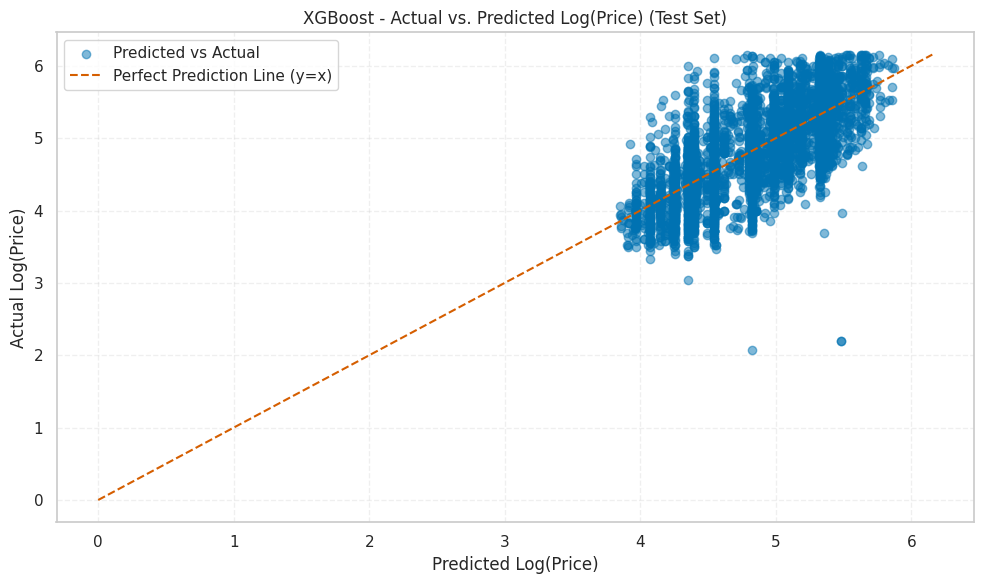

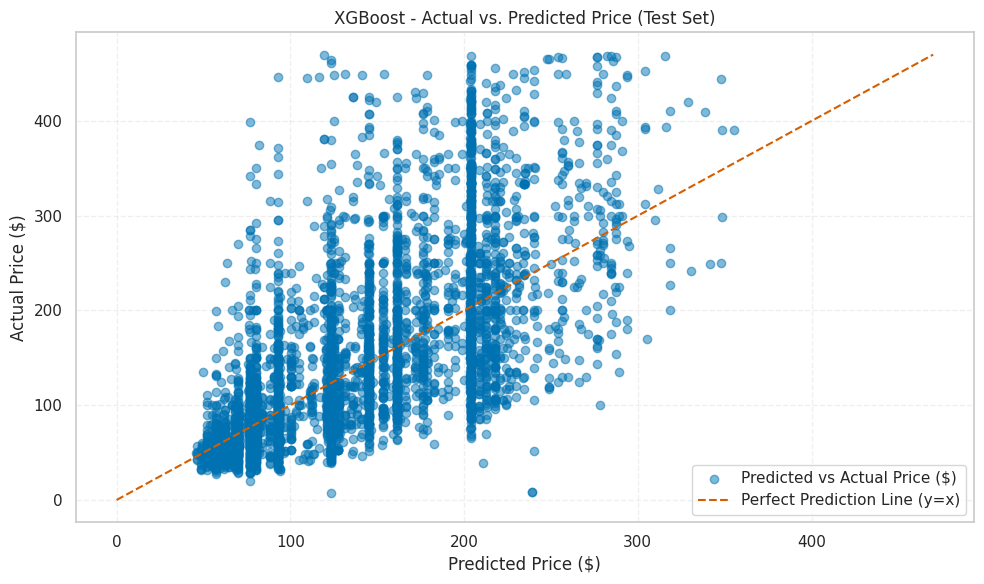

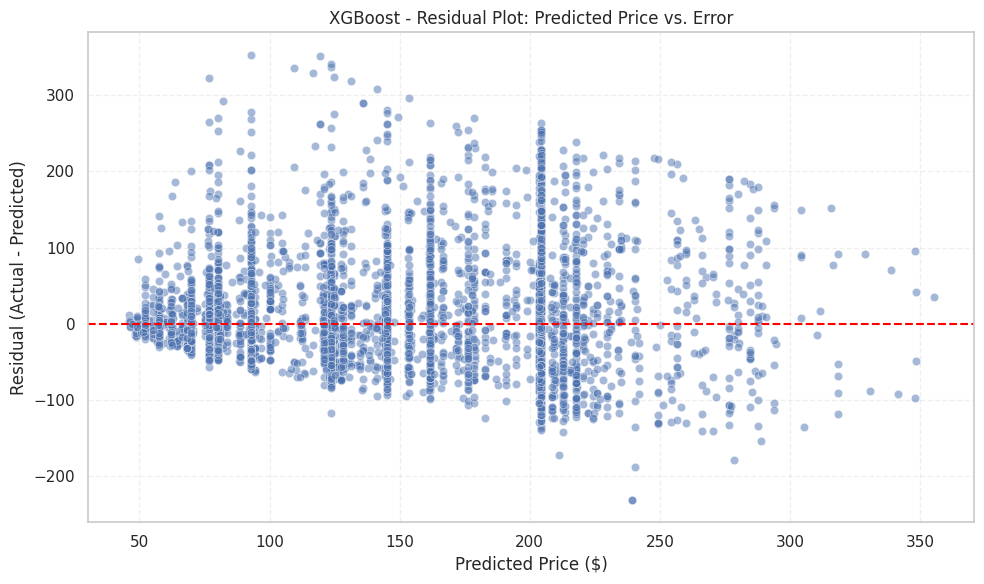

<ipython-input-20-e9c34c5fa89d>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


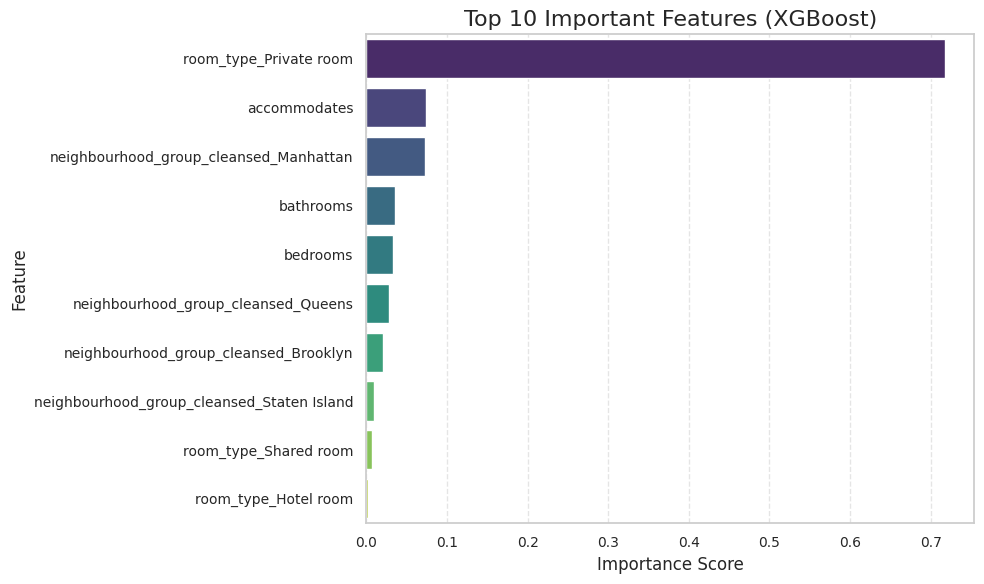

In [ ]:
# Scatter plot: Predicted vs. Actual (log scale)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_xgb, y_test, alpha=0.5, color='#0072B2', label='Predicted vs Actual')
max_val = max(y_test.max(), y_pred_test_xgb.max())
plt.plot([0, max_val], [0, max_val], '--', color='#D55E00', label='Perfect Prediction Line (y=x)')
plt.title('XGBoost - Actual vs. Predicted Log(Price) (Test Set)')
plt.xlabel('Predicted Log(Price)')
plt.ylabel('Actual Log(Price)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs. Actual (original price)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_price_xgb, y_test_price, alpha=0.5, color='#0072B2', label='Predicted vs Actual Price ($)')
max_val_price = max(y_test_price.max(), y_pred_test_price_xgb.max())
plt.plot([0, max_val_price], [0, max_val_price], '--', color='#D55E00', label='Perfect Prediction Line (y=x)')
plt.title('XGBoost - Actual vs. Predicted Price (Test Set)')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Actual Price ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Residual plot: Error distribution (original price)
residuals_xgb = y_test_price - y_pred_test_price_xgb

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test_price_xgb, y=residuals_xgb, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title('XGBoost - Residual Plot: Predicted Price vs. Error')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot the top 10 important features for XGBoost with improved formatting
importances_xgb = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importance
feat_imp_xgb_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_xgb})
feat_imp_xgb_df = feat_imp_xgb_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))

# Use a modern color palette ('viridis') for consistency
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_xgb_df.head(10),
    palette='viridis'
)

# Set plot title and axis labels
plt.title('Top 10 Important Features (XGBoost)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Adjust tick label sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()


# 📊 Model Comparison Summary


In [ ]:
# Build the summary table
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R² (Log Price)': [0.411, 0.493, 0.491],
    'RMSE (Log Price)': [0.485, 0.450, 0.451],
    'R² (Original Price)': [0.301, 0.398, 0.393],
    'RMSE (Original Price)': [82.78, 76.81, 77.13]
})

# Display with nice formatting
model_comparison.style.format({
    'R² (Log Price)': "{:.3f}",
    'RMSE (Log Price)': "{:.3f}",
    'R² (Original Price)': "{:.3f}",
    'RMSE (Original Price)': "{:.2f}"
}).set_properties(**{'text-align': 'center'}) \
 .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

,Model,R² (Log Price),RMSE (Log Price),R² (Original Price),RMSE (Original Price)
0,Linear Regression,0.411,0.485,0.301,82.78
1,Random Forest,0.493,0.450,0.398,76.81
2,XGBoost,0.491,0.451,0.393,77.13


## 🔎 Key Insights
- **Random Forest** achieved the **highest R²** and **lowest RMSE** on both the log-transformed and original price scales.
- **XGBoost** also performed competitively, with performance very close to Random Forest.
- **Linear Regression** was outperformed by both ensemble models, reflecting its limitations in capturing complex relationships in the data.

## 🏆 Best Model
> **Random Forest** is selected as the best performing model overall, offering the best balance between explanatory power and prediction accuracy.